## Preparing Visualizations to examine delays based on locations

### Preliminary Analyses of Delays per Location

In [1]:
# Import Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt
import PIL
import requests
import seaborn as sns
import pandas as pd
import scipy
import os
from glob import glob

In [2]:
# Import the Excel file as a dataframe and examine it.  Note that this excel file went through additional cleaning to wrangle the location data.

cleaned_df = pd.read_excel('ttc-streetcar-delay-data-2024_cleaned_extra_CAR.xlsx', index_col=None)
cleaned_df.head()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
0,2024-12-06,511,04:45,Friday,YORKDALE STATION,Mechanical,10,20,S,3518,12,49,6,4,Fall
1,2024-12-10,501,11:58,Tuesday,YORK AND YONGE,General Delay,12,22,E,4442,12,50,10,11,Fall
2,2024-01-01,501,14:26,Monday,YORK AND WELLINGTON,Security,5,15,N,4572,1,1,1,14,Winter
3,2024-01-10,501,22:28,Wednesday,YORK AND WELLINGTON,Security,50,60,W,4543,1,2,10,22,Winter
4,2024-05-09,501,00:24,Thursday,YORK AND WELLINGTON,Emergency Services,0,0,W,4505,5,19,9,0,Spring


In [3]:
# Check how many unique locations are in this dataframe

print(cleaned_df['Location'].nunique())

1416


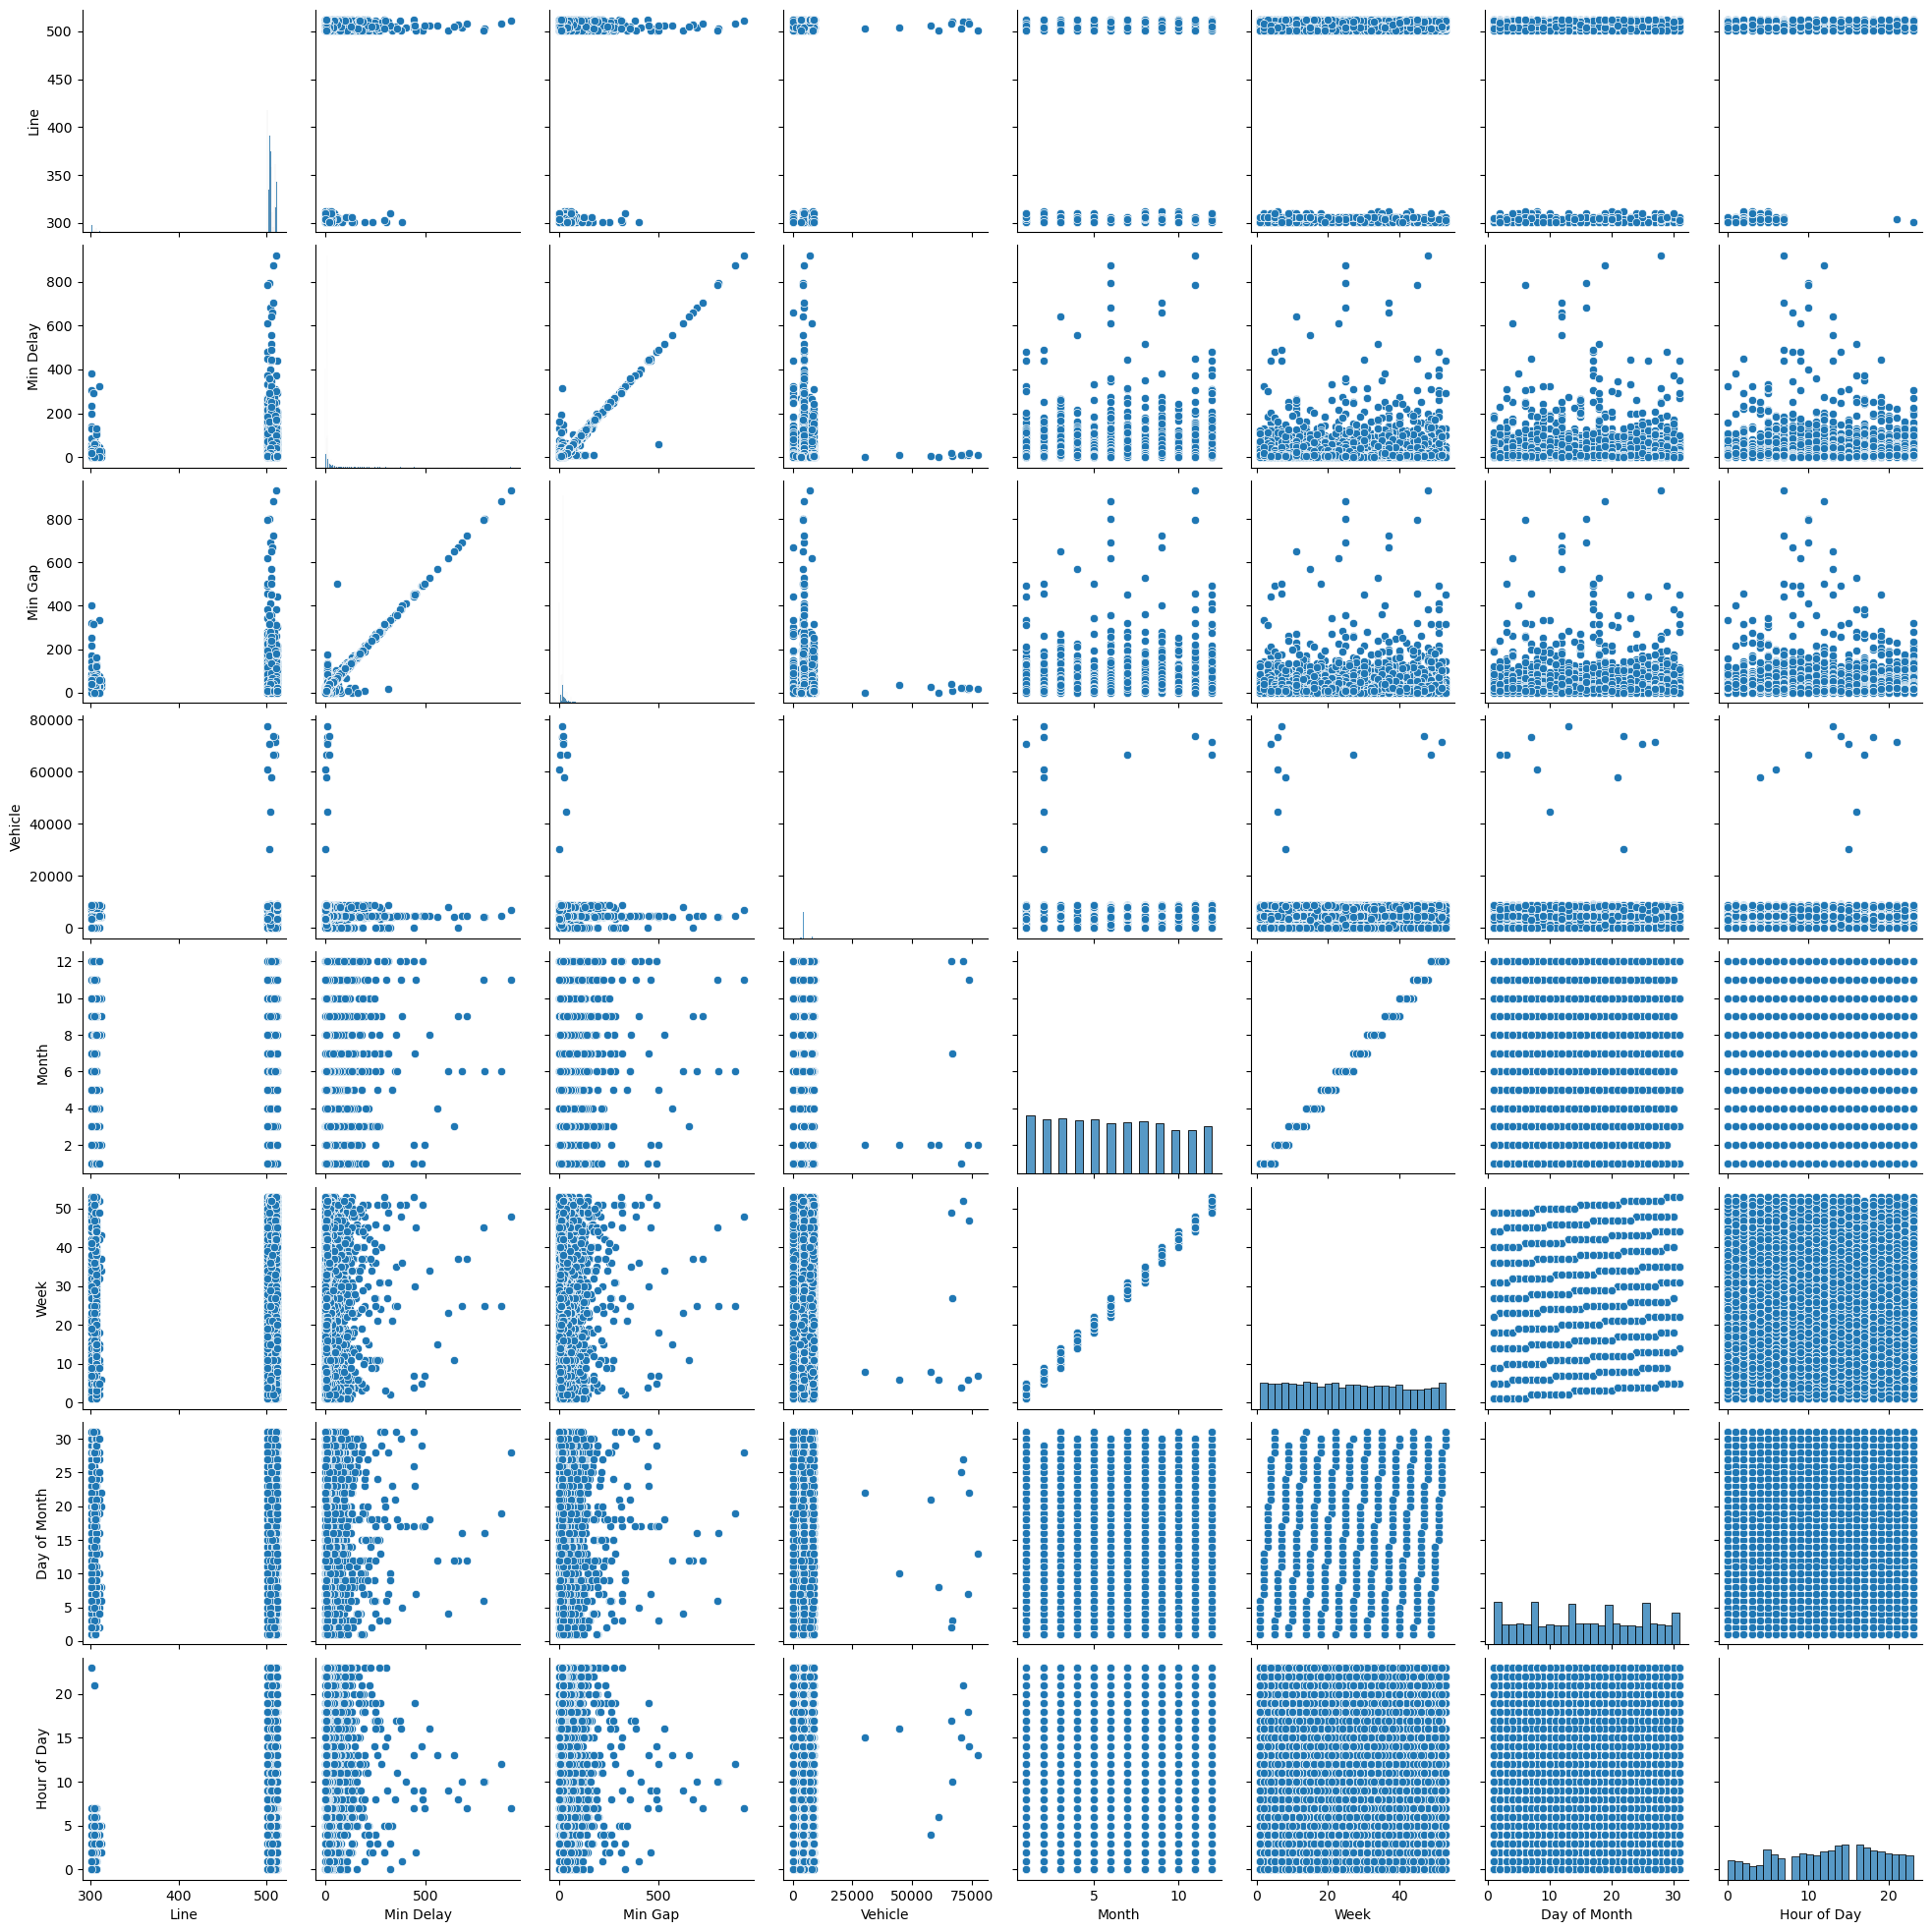

In [4]:
# Examine the numerical columns to look for correlations.  There are only well defined correlations between "Min Gap" and "Min Delay".  
# Will need to use visualizations to examine additional relationships.

sns.pairplot(cleaned_df)

In [5]:
# Look at the columns in the dataframe

cleaned_df.columns

Index(['Date', 'Line', 'Time', 'Day', 'Location', 'Incident', 'Min Delay',
       'Min Gap', 'Bound', 'Vehicle', 'Month', 'Week', 'Day of Month',
       'Hour of Day', 'Season'],
      dtype='object')

In [6]:
# Look at how many rows are in the dataframe
cleaned_df.shape[0]

13931

This notebook will look for relationships between delays and location, with some additional information on type of incident.  Need to create a new dataframe that is organized by these features.

In [7]:
# Create a new dataframe that is organized by location and type of incident.  Will count incidents per location.

# Numbers of incident types at each location is recorded as "Count".

num = (
    cleaned_df
    .groupby(['Location', 'Incident'])
    .size()
    .reset_index(name='Count')
)

# Total number of incidents per location, not organized by incident type.  This value is recorded as "Total Incidents at Location"
totals = (
    cleaned_df
    .groupby('Location')
    .size()
    .reset_index(name='Total Incidents at Location')
)

# Merge the dataframes to obtain both overall incident numbers and numbers of each type of incident.

Num_Incident_Type_per_Location_Filtered = num.merge(totals, on='Location', how='left')

# Ensure the values are integers.
Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'] = Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'].astype(int)

Num_Incident_Type_per_Location_Filtered.tail(20)

,Location,Incident,Count,Total Incidents at Location
4074,YONGE AND KING,Utilized Off Route,1,77
4075,YONGE AND LOLA,Collision - TTC Involved,1,1
4076,YORK AND ADELAIDE,Held By,1,1
4077,YORK AND KING,Cleaning - Unsanitary,18,83
4078,YORK AND KING,Diversion,6,83
4079,YORK AND KING,Emergency Services,15,83
4080,YORK AND KING,General Delay,8,83
4081,YORK AND KING,Held By,6,83
4082,YORK AND KING,Mechanical,5,83
4083,YORK AND KING,Operations,13,83


In [8]:
# Checking the number of rows in the dataframe

Num_Incident_Type_per_Location_Filtered.shape[0]

4094

In [9]:
# Checking the number of unique locations in this dataframe.

Num_Incident_Type_per_Location_Filtered['Location'].nunique()

1416

In [10]:
# Pivoting the dataframe to make it easier to plot, as suggested by ChatGPT.

df_wide = Num_Incident_Type_per_Location_Filtered.pivot(
    index='Location',
    columns='Incident',
    values='Count'
).fillna(0)

df_wide.head()

Incident,Cleaning - Unsanitary,Collision - TTC Involved,Diversion,Emergency Services,General Delay,Held By,Investigation,Mechanical,Operations,Overhead,Rail/Switches,Security,Utilized Off Route
Location,,,,,,,,,,,,,
AND DEER PARK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AND EARLS COU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AND GLENHOLME,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AND KEELE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AND OAKWOOD,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_wide.shape[0]

1416

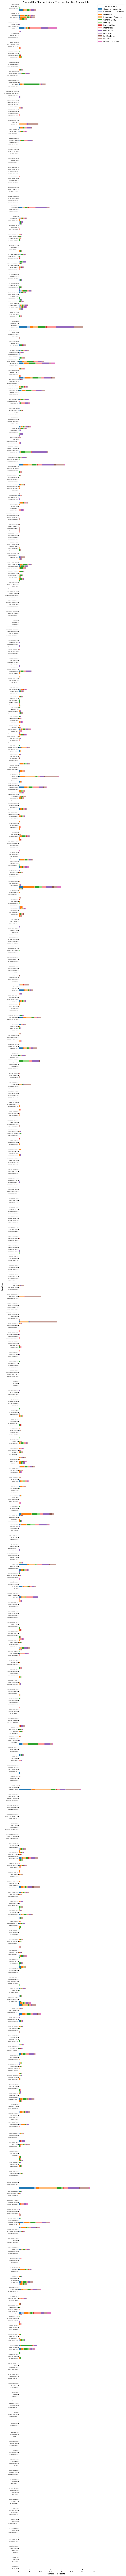

In [12]:
# Creating an horizontal bar graph where, for each location, numbers of incidents in 2024 at that location are shown as stacked colors.

fig, ax = plt.subplots(figsize=(10, 200))

# Track cumulative values for stacking
left = pd.Series([0]*len(df_wide), index=df_wide.index)

colors = plt.cm.tab20.colors

# Loop through incident types
for i, incident in enumerate(df_wide.columns):
    ax.barh(df_wide.index, df_wide[incident],
            left=left,
            label=incident,
            color=colors[i % len(colors)])
    left += df_wide[incident]

# Labels and legend
ax.set_ylabel('Location')
ax.set_xlabel('Number of Incidents')
ax.set_title('Stacked Bar Chart of Incident Types per Location (Horizontal)')
ax.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.tick_params(axis='y', labelsize=4)

# Configure some axes parameters

plt.xlim(0, 350)
ax.margins(y=0) 

# Display plot

plt.tight_layout()
plt.show()

That is too many locations for an easy visualization!  Let's think about how to better break down the data.  Some locations are clearly more incident prone than others.  Will group locations based on number of total incidents in 2024.

### Creating a Dataframe that Groups Locations per Incident Frequency

In [13]:
# Sort Stations into categories based on incident count.  Had help from ChatGPT.

conditions = [
    Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'] < 10,
    Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'].between(10, 49),
    Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'].between(50, 99),
    Num_Incident_Type_per_Location_Filtered['Total Incidents at Location'] >= 100
]
choices = ['Less than 10', '10 to 49', '50 to 99', '100 or More']

Num_Incident_Type_per_Location_Filtered['Location Category'] = np.select(conditions, choices)
Num_Incident_Type_per_Location_Filtered.head()

,Location,Incident,Count,Total Incidents at Location,Location Category
0,AND DEER PARK,Operations,1,1,Less than 10
1,AND EARLS COU,Collision - TTC Involved,1,1,Less than 10
2,AND GLENHOLME,Mechanical,1,1,Less than 10
3,AND KEELE,Operations,1,1,Less than 10
4,AND OAKWOOD,General Delay,1,1,Less than 10


In [14]:
# Counting number of rows in the dataframe again

Num_Incident_Type_per_Location_Filtered.shape[0]

4094

In [15]:
# Find high incident locations

High_Incident_Locations = Num_Incident_Type_per_Location_Filtered[Num_Incident_Type_per_Location_Filtered['Location Category']== '100 or More']
High_Incident_Locations

,Location,Incident,Count,Total Incidents at Location,Location Category
211,BATHURST AND QUEEN,Cleaning - Unsanitary,11,152,100 or More
212,BATHURST AND QUEEN,Collision - TTC Involved,13,152,100 or More
213,BATHURST AND QUEEN,Diversion,19,152,100 or More
214,BATHURST AND QUEEN,Emergency Services,12,152,100 or More
215,BATHURST AND QUEEN,General Delay,9,152,100 or More
...,...,...,...,...,...
4032,WOLSELEY LOOP,Investigation,3,182,100 or More
4033,WOLSELEY LOOP,Mechanical,55,182,100 or More
4034,WOLSELEY LOOP,Operations,33,182,100 or More
4035,WOLSELEY LOOP,Security,5,182,100 or More


In [16]:
# Checking the datatypes

High_Incident_Locations.dtypes

Location                       object
Incident                       object
Count                           int64
Total Incidents at Location     int64
Location Category              object
dtype: object

In [17]:
# How many unique "high incident locations" exist?

High_Incident_Locations['Location'].nunique()

27

In [18]:
# Convert this dataframe into a wide table so that it can be more easily plotted.

High_Incident_Locations_wide = High_Incident_Locations.pivot_table(
    index='Location',
    columns='Incident',
    values='Count',
    fill_value=0
)
High_Incident_Locations_wide.head()

Incident,Cleaning - Unsanitary,Collision - TTC Involved,Diversion,Emergency Services,General Delay,Held By,Investigation,Mechanical,Operations,Overhead,Rail/Switches,Security,Utilized Off Route
Location,,,,,,,,,,,,,
BATHURST AND QUEEN,11.0,13.0,19.0,12.0,9.0,5.0,2.0,35.0,14.0,0.0,0.0,15.0,17.0
BATHURST STATION,12.0,1.0,6.0,22.0,12.0,2.0,1.0,9.0,23.0,0.0,0.0,14.0,3.0
BROADVIEW AND GERRARD,19.0,6.0,22.0,8.0,22.0,4.0,2.0,27.0,17.0,0.0,2.0,15.0,4.0
BROADVIEW STATION,74.0,7.0,14.0,86.0,20.0,8.0,2.0,22.0,52.0,1.0,2.0,45.0,1.0
COXWELL AND GERRARD,15.0,0.0,13.0,11.0,16.0,4.0,0.0,10.0,19.0,0.0,1.0,13.0,1.0


/var/folders/lk/v5dfvh9d0799xjl8_99hhnhw0000gn/T/ipykernel_45226/1253649531.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl_colors = colors = plt.cm.get_cmap('tab10').colors
/var/folders/lk/v5dfvh9d0799xjl8_99hhnhw0000gn/T/ipykernel_45226/1253649531.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(High_Incident_Locations_wide.index, rotation=45, ha='right', fontsize=8)


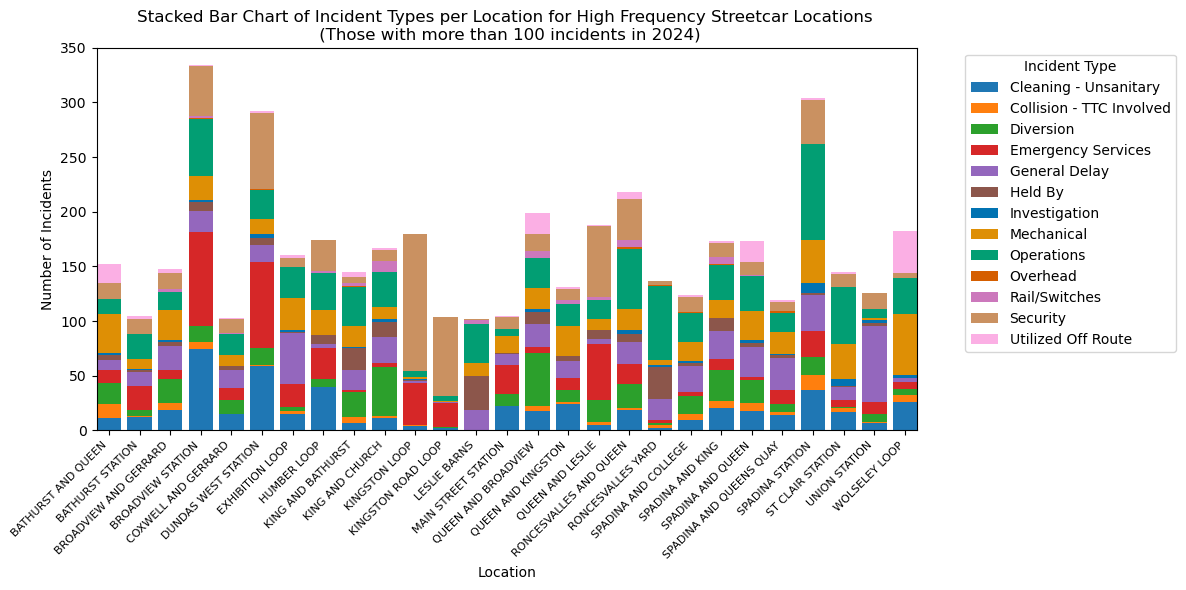

In [19]:
# Create a bar plot of only these high incident locations, showing how many types of each incident they experienced.

fig, ax = plt.subplots(figsize=(12, 6))

# Track cumulative values for stacking
bottom = pd.Series([0]*len(High_Incident_Locations_wide), index=High_Incident_Locations_wide.index)

seaborn_colors = sns.color_palette("colorblind", n_colors=len(High_Incident_Locations_wide.columns))
mpl_colors = colors = plt.cm.get_cmap('tab10').colors
combined_colors = list(mpl_colors[:6]) + list(seaborn_colors[:8])

# Loop through incident types
for i, incident in enumerate(High_Incident_Locations_wide.columns):
    ax.bar(High_Incident_Locations_wide.index, High_Incident_Locations_wide[incident],
            bottom=bottom,
            label=incident,
            color=combined_colors[i])
    bottom += High_Incident_Locations_wide[incident]

# Labels and legend
ax.set_ylabel('Number of Incidents')
ax.set_xlabel('Location')
ax.set_title('Stacked Bar Chart of Incident Types per Location for High Frequency Streetcar Locations \n (Those with more than 100 incidents in 2024)')
ax.legend(title='Incident Type', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticklabels(High_Incident_Locations_wide.index, rotation=45, ha='right', fontsize=8)

plt.ylim(0, 350)
ax.margins(x=0) 

plt.tight_layout()
plt.show()

This bar plot is useful!  It identifies high incident stations where TTC can focus efforts on minimizing delays.  I would like to further analyze the data and determine what percentage of total delays and total delay times are accounted for by these 27 stations.

### Creating a Dataframe that Tabulates Percentage of Incidents and Minutes of Delay per Location Type

In [20]:
# Also tabulate the number of other location types
Less_than_10_List = Num_Incident_Type_per_Location_Filtered[Num_Incident_Type_per_Location_Filtered['Location Category']== 'Less than 10']
Between_10_and_50 = Num_Incident_Type_per_Location_Filtered[Num_Incident_Type_per_Location_Filtered['Location Category']== '10 to 49']
Between_50_and_100 = Num_Incident_Type_per_Location_Filtered[Num_Incident_Type_per_Location_Filtered['Location Category']== '50 to 99']

# Collect all the data on incidents in different location types into a dictionary.

location_data_summary = {'Location Category': choices, 
                         'Number of Locations in Category' : [Less_than_10_List['Location'].nunique(), Between_10_and_50['Location'].nunique(), 
                                                 Between_50_and_100['Location'].nunique(), High_Incident_Locations['Location'].nunique() ],
}
print(location_data_summary)

{'Location Category': ['Less than 10', '10 to 49', '50 to 99', '100 or More'], 'Number of Locations in Category': [1149, 197, 43, 27]}


In [21]:
# Convert that dictionary into a dataframe

location_data_df = pd.DataFrame(location_data_summary)
location_data_df

,Location Category,Number of Locations in Category
0,Less than 10,1149
1,10 to 49,197
2,50 to 99,43
3,100 or More,27


In [22]:
# Sum the total number of incidents in each location category.  
Location_Category_Count = Num_Incident_Type_per_Location_Filtered.groupby('Location Category', as_index=False)['Count'].sum()
Location_Category_Count.head(20)

,Location Category,Count
0,10 to 49,4216
1,100 or More,4490
2,50 to 99,2902
3,Less than 10,2322


In [23]:
# Merge this dataframe with a prior dataframe that tabulates number of locations in each category.
Locations_df = pd.merge(location_data_df, Location_Category_Count, on = 'Location Category')
Locations_df

,Location Category,Number of Locations in Category,Count
0,Less than 10,1149,2322
1,10 to 49,197,4216
2,50 to 99,43,2902
3,100 or More,27,4490


In [24]:
# Add a row that tabulates the sum of each column

sum_row = Locations_df.select_dtypes(include='number').sum()
df_with_total = pd.concat([Locations_df, pd.DataFrame([sum_row])], ignore_index=True)

df_with_total

,Location Category,Number of Locations in Category,Count
0,Less than 10,1149,2322
1,10 to 49,197,4216
2,50 to 99,43,2902
3,100 or More,27,4490
4,NaN,1416,13930


In [25]:
# Want to calculate percentage of total locations and total incidents for each location category

df_with_total['Percentage of Total Locations'] = df_with_total['Number of Locations in Category']*200/((df_with_total['Number of Locations in Category'].sum()))
df_with_total['Percentage of Total Incidents'] = df_with_total['Count']*200/((df_with_total['Count'].sum()))
df_with_total["Percentage of Total Locations"] = df_with_total['Percentage of Total Locations'].round(2)
df_with_total["Percentage of Total Incidents"] = df_with_total['Percentage of Total Incidents'].round(2)
df_with_total

,Location Category,Number of Locations in Category,Count,Percentage of Total Locations,Percentage of Total Incidents
0,Less than 10,1149,2322,81.14,16.67
1,10 to 49,197,4216,13.91,30.27
2,50 to 99,43,2902,3.04,20.83
3,100 or More,27,4490,1.91,32.23
4,NaN,1416,13930,100.00,100.00


In [26]:
# Rename columns
df_with_total = df_with_total.rename(columns = {'Location Category' : 'Location Category (Number of Incidents per Year)', 'Count': 'Number of Incidents in this Category'})
df_with_total

,Location Category (Number of Incidents per Year),Number of Locations in Category,Number of Incidents in this Category,Percentage of Total Locations,Percentage of Total Incidents
0,Less than 10,1149,2322,81.14,16.67
1,10 to 49,197,4216,13.91,30.27
2,50 to 99,43,2902,3.04,20.83
3,100 or More,27,4490,1.91,32.23
4,NaN,1416,13930,100.00,100.00


In [27]:
# Remove the "NaN" from Row 4, column 1.

df_with_total.at[4, 'Location Category (Number of Incidents per Year)'] = 'Total'
df_with_total

,Location Category (Number of Incidents per Year),Number of Locations in Category,Number of Incidents in this Category,Percentage of Total Locations,Percentage of Total Incidents
0,Less than 10,1149,2322,81.14,16.67
1,10 to 49,197,4216,13.91,30.27
2,50 to 99,43,2902,3.04,20.83
3,100 or More,27,4490,1.91,32.23
4,Total,1416,13930,100.00,100.00


In [28]:
# Begin building a dataframe that also tracks the cumulative minutes of delay at each station

minutes_df = (
    cleaned_df
    .groupby('Location')['Min Delay']
    .sum(numeric_only=True).reset_index()
    .rename(columns = {'Min Delay': 'Total Minutes of Delay'})
)

minutes_df

,Location,Total Minutes of Delay
0,AND DEER PARK,5
1,AND EARLS COU,4
2,AND GLENHOLME,10
3,AND KEELE,8
4,AND OAKWOOD,0
...,...,...
1411,YORK AND ADELAIDE,0
1412,YORK AND KING,1843
1413,YORK AND WELLINGTON,451
1414,YORK AND YONGE,12


In [29]:
# Take the total incident dataframe and aggregate so that there is only one row per location

incidents_location = (
    Num_Incident_Type_per_Location_Filtered.groupby(['Location', 'Location Category'], as_index=False)
    .agg({'Count': 'sum'}).rename(columns = {'Count': 'Total Incidents'
    })
)

incidents_location


,Location,Location Category,Total Incidents
0,AND DEER PARK,Less than 10,1
1,AND EARLS COU,Less than 10,1
2,AND GLENHOLME,Less than 10,1
3,AND KEELE,Less than 10,1
4,AND OAKWOOD,Less than 10,1
...,...,...,...
1411,YORK AND ADELAIDE,Less than 10,1
1412,YORK AND KING,50 to 99,83
1413,YORK AND WELLINGTON,Less than 10,8
1414,YORK AND YONGE,Less than 10,1


In [30]:
# Merge the cumulative minutes of delay with prior dataframe showing number of incident types per location

merged_min_type = pd.merge(minutes_df, incidents_location, on = 'Location', how = 'inner')
merged_min_type.tail(10)

,Location,Total Minutes of Delay,Location Category,Total Incidents
1406,WYCHWOOD AND ST CLAIR,3,Less than 10,1
1407,YONGE AND COLLEGE,598,10 to 49,37
1408,YONGE AND DUNDAS,1584,50 to 99,77
1409,YONGE AND KING,1518,50 to 99,77
1410,YONGE AND LOLA,0,Less than 10,1
1411,YORK AND ADELAIDE,0,Less than 10,1
1412,YORK AND KING,1843,50 to 99,83
1413,YORK AND WELLINGTON,451,Less than 10,8
1414,YORK AND YONGE,12,Less than 10,1
1415,YORKDALE STATION,10,Less than 10,1


In [31]:
# Tabulate minutes of delay per category

yet_another_df = merged_min_type.groupby('Location Category', as_index = False).agg({'Total Minutes of Delay': 'sum'})
yet_another_df

,Location Category,Total Minutes of Delay
0,10 to 49,74076
1,100 or More,59581
2,50 to 99,42739
3,Less than 10,48943


In [32]:
# Add a summary row

sum_row2 = yet_another_df.select_dtypes(include='number').sum()
another_df_with_total = pd.concat([yet_another_df, pd.DataFrame([sum_row2])], ignore_index=True)

another_df_with_total

,Location Category,Total Minutes of Delay
0,10 to 49,74076
1,100 or More,59581
2,50 to 99,42739
3,Less than 10,48943
4,NaN,225339


In [33]:
# Calcuate the percentage of total minutes delayed per location category

another_df_with_total['Percentage of Total Minutes of Delay'] = (another_df_with_total['Total Minutes of Delay']*200/(another_df_with_total['Total Minutes of Delay'].sum()))
another_df_with_total["Percentage of Total Minutes of Delay"] = (another_df_with_total['Percentage of Total Minutes of Delay'].round(2))

another_df_with_total

,Location Category,Total Minutes of Delay,Percentage of Total Minutes of Delay
0,10 to 49,74076,32.87
1,100 or More,59581,26.44
2,50 to 99,42739,18.97
3,Less than 10,48943,21.72
4,NaN,225339,100.00


In [34]:
# Remove "NaN"
another_df_with_total.at[4, 'Location Category'] = 'Total'
another_df_with_total

,Location Category,Total Minutes of Delay,Percentage of Total Minutes of Delay
0,10 to 49,74076,32.87
1,100 or More,59581,26.44
2,50 to 99,42739,18.97
3,Less than 10,48943,21.72
4,Total,225339,100.00


In [35]:
# Rename columns
another_df_with_total2 = another_df_with_total.rename(columns= {'Location Category': 'Location Category (Number of Incidents per Year)'})
another_df_with_total2

,Location Category (Number of Incidents per Year),Total Minutes of Delay,Percentage of Total Minutes of Delay
0,10 to 49,74076,32.87
1,100 or More,59581,26.44
2,50 to 99,42739,18.97
3,Less than 10,48943,21.72
4,Total,225339,100.00


The cell below is important!  It shows that just under 2% of the total locations account for around 32% of the total incidents and ~26% of the total minutes of delay.  Focusing on these stations would enable TTC to make a big impact in overall delay time.

In [36]:
# Calculate percentages of total incidents and total delay time per location category

totals_df = pd.merge(df_with_total, another_df_with_total2, on = 'Location Category (Number of Incidents per Year)')
totals_df

,Location Category (Number of Incidents per Year),Number of Locations in Category,Number of Incidents in this Category,Percentage of Total Locations,Percentage of Total Incidents,Total Minutes of Delay,Percentage of Total Minutes of Delay
0,Less than 10,1149,2322,81.14,16.67,48943,21.72
1,10 to 49,197,4216,13.91,30.27,74076,32.87
2,50 to 99,43,2902,3.04,20.83,42739,18.97
3,100 or More,27,4490,1.91,32.23,59581,26.44
4,Total,1416,13930,100.00,100.00,225339,100.00


### Make a plot that displays both location frequency and delay time per incidient type for high incident locations.

In [37]:
# Revisit a prior dataframe

High_Incident_Locations

,Location,Incident,Count,Total Incidents at Location,Location Category
211,BATHURST AND QUEEN,Cleaning - Unsanitary,11,152,100 or More
212,BATHURST AND QUEEN,Collision - TTC Involved,13,152,100 or More
213,BATHURST AND QUEEN,Diversion,19,152,100 or More
214,BATHURST AND QUEEN,Emergency Services,12,152,100 or More
215,BATHURST AND QUEEN,General Delay,9,152,100 or More
...,...,...,...,...,...
4032,WOLSELEY LOOP,Investigation,3,182,100 or More
4033,WOLSELEY LOOP,Mechanical,55,182,100 or More
4034,WOLSELEY LOOP,Operations,33,182,100 or More
4035,WOLSELEY LOOP,Security,5,182,100 or More


In [38]:
# Create a dataframe of only high incident locations, one location per row

High_Incident_Locations_list = High_Incident_Locations['Location'].unique()
High_Incident_Locations_df = pd.DataFrame(High_Incident_Locations_list, columns=['Location'])

High_Incident_Locations_df

,Location
0,BATHURST AND QUEEN
1,BATHURST STATION
2,BROADVIEW AND GERRARD
3,BROADVIEW STATION
4,COXWELL AND GERRARD
5,DUNDAS WEST STATION
6,EXHIBITION LOOP
7,HUMBER LOOP
8,KING AND BATHURST
9,KING AND CHURCH


In [39]:
# Create a dataframe that tracks total minutes of delay at each location for high incident locations.  Will use in figure below.

more_totals = pd.merge(minutes_df, High_Incident_Locations_df, on='Location', how='inner')
more_totals

,Location,Total Minutes of Delay
0,BATHURST AND QUEEN,1936
1,BATHURST STATION,1213
2,BROADVIEW AND GERRARD,1886
3,BROADVIEW STATION,4166
4,COXWELL AND GERRARD,1872
5,DUNDAS WEST STATION,4268
6,EXHIBITION LOOP,1456
7,HUMBER LOOP,2280
8,KING AND BATHURST,3072
9,KING AND CHURCH,4488


In [40]:
# Using the high incident dataframe and sorting by number of total incidents.

High_Incident_Locations_sorted_descending = High_Incident_Locations.sort_values(by = 'Total Incidents at Location', ascending = False)
High_Incident_Locations_sorted_descending

,Location,Incident,Count,Total Incidents at Location,Location Category
457,BROADVIEW STATION,Investigation,2,334,100 or More
451,BROADVIEW STATION,Cleaning - Unsanitary,74,334,100 or More
453,BROADVIEW STATION,Diversion,14,334,100 or More
454,BROADVIEW STATION,Emergency Services,86,334,100 or More
455,BROADVIEW STATION,General Delay,20,334,100 or More
...,...,...,...,...,...
2239,LESLIE BARNS,Held By,31,102,100 or More
2241,LESLIE BARNS,Operations,35,102,100 or More
2242,LESLIE BARNS,Rail/Switches,4,102,100 or More
2243,LESLIE BARNS,Security,1,102,100 or More


In [41]:
# List high incident stations in descending order from most incidents to fewest incidents

Descending_List = High_Incident_Locations_sorted_descending['Location'].unique()
Descending_List

array(['BROADVIEW STATION', 'SPADINA STATION', 'DUNDAS WEST STATION',
       'RONCESVALLES AND QUEEN', 'QUEEN AND BROADVIEW',
       'QUEEN AND LESLIE', 'WOLSELEY LOOP', 'KINGSTON LOOP',
       'HUMBER LOOP', 'SPADINA AND KING', 'SPADINA AND QUEEN',
       'KING AND CHURCH', 'EXHIBITION LOOP', 'BATHURST AND QUEEN',
       'BROADVIEW AND GERRARD', 'ST CLAIR STATION', 'KING AND BATHURST',
       'RONCESVALLES YARD', 'QUEEN AND KINGSTON', 'UNION STATION',
       'SPADINA AND COLLEGE', 'SPADINA AND QUEENS QUAY',
       'BATHURST STATION', 'MAIN STREET STATION', 'KINGSTON ROAD LOOP',
       'COXWELL AND GERRARD', 'LESLIE BARNS'], dtype=object)

In [42]:
# Convert array to list

Descending_List = Descending_List.tolist()
Descending_List

['BROADVIEW STATION',
 'SPADINA STATION',
 'DUNDAS WEST STATION',
 'RONCESVALLES AND QUEEN',
 'QUEEN AND BROADVIEW',
 'QUEEN AND LESLIE',
 'WOLSELEY LOOP',
 'KINGSTON LOOP',
 'HUMBER LOOP',
 'SPADINA AND KING',
 'SPADINA AND QUEEN',
 'KING AND CHURCH',
 'EXHIBITION LOOP',
 'BATHURST AND QUEEN',
 'BROADVIEW AND GERRARD',
 'ST CLAIR STATION',
 'KING AND BATHURST',
 'RONCESVALLES YARD',
 'QUEEN AND KINGSTON',
 'UNION STATION',
 'SPADINA AND COLLEGE',
 'SPADINA AND QUEENS QUAY',
 'BATHURST STATION',
 'MAIN STREET STATION',
 'KINGSTON ROAD LOOP',
 'COXWELL AND GERRARD',
 'LESLIE BARNS']

In [43]:
# Pivot High Incidents Location dataframe to a wide format for plotting

High_Incident_Locations_wide = High_Incident_Locations.pivot_table(
    index='Location',
    columns='Incident',
    values='Count',
    fill_value=0
)
High_Incident_Locations_wide.head()

Incident,Cleaning - Unsanitary,Collision - TTC Involved,Diversion,Emergency Services,General Delay,Held By,Investigation,Mechanical,Operations,Overhead,Rail/Switches,Security,Utilized Off Route
Location,,,,,,,,,,,,,
BATHURST AND QUEEN,11.0,13.0,19.0,12.0,9.0,5.0,2.0,35.0,14.0,0.0,0.0,15.0,17.0
BATHURST STATION,12.0,1.0,6.0,22.0,12.0,2.0,1.0,9.0,23.0,0.0,0.0,14.0,3.0
BROADVIEW AND GERRARD,19.0,6.0,22.0,8.0,22.0,4.0,2.0,27.0,17.0,0.0,2.0,15.0,4.0
BROADVIEW STATION,74.0,7.0,14.0,86.0,20.0,8.0,2.0,22.0,52.0,1.0,2.0,45.0,1.0
COXWELL AND GERRARD,15.0,0.0,13.0,11.0,16.0,4.0,0.0,10.0,19.0,0.0,1.0,13.0,1.0


In [44]:
# Sort the dataframe of number of minutes by location in descending order by number of incidents per location.  Need this order to make the figure below.

more_totals['Location'] = pd.Categorical(more_totals['Location'], categories = Descending_List, ordered = True)
more_totals = more_totals.sort_values('Location')
more_totals

,Location,Total Minutes of Delay
3,BROADVIEW STATION,4166
23,SPADINA STATION,2766
5,DUNDAS WEST STATION,4268
17,RONCESVALLES AND QUEEN,3283
14,QUEEN AND BROADVIEW,3620
16,QUEEN AND LESLIE,1504
26,WOLSELEY LOOP,3156
10,KINGSTON LOOP,892
7,HUMBER LOOP,2280
20,SPADINA AND KING,3343


/var/folders/lk/v5dfvh9d0799xjl8_99hhnhw0000gn/T/ipykernel_45226/2891353229.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mpl_colors = colors = plt.cm.get_cmap('tab10').colors
/var/folders/lk/v5dfvh9d0799xjl8_99hhnhw0000gn/T/ipykernel_45226/2891353229.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(High_Incident_Locations_wide.index, rotation=45, ha='right', fontsize=8)


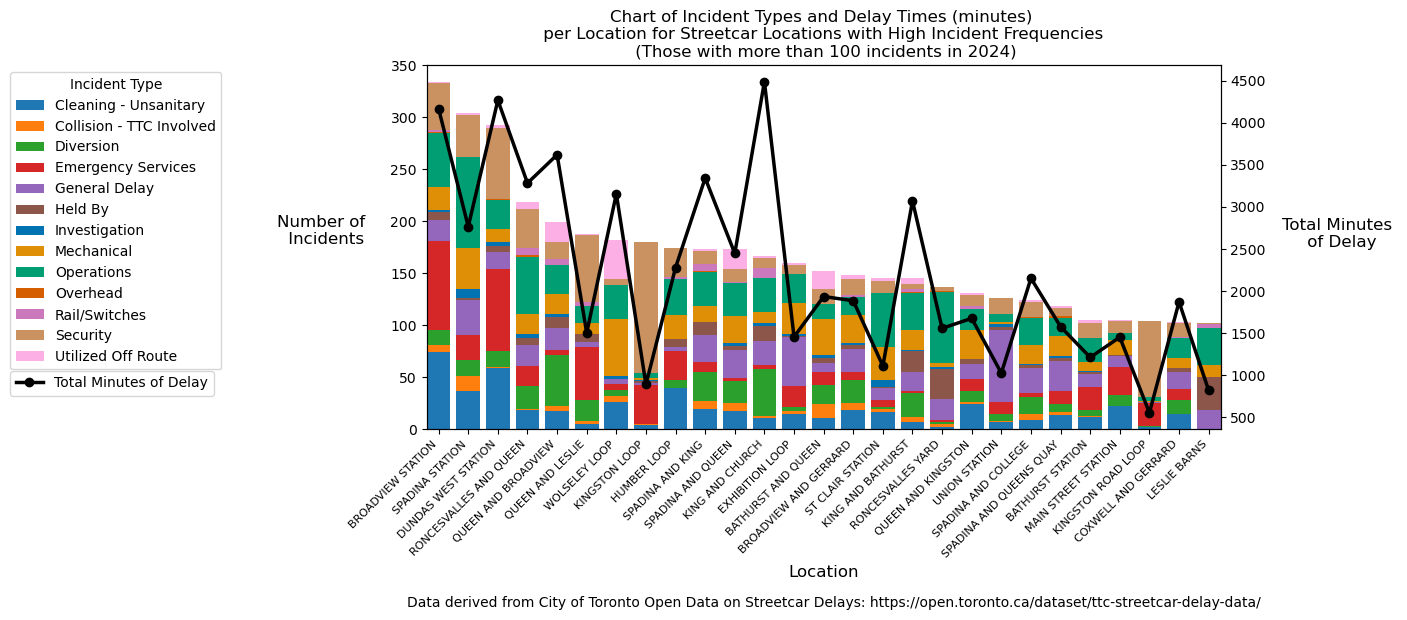

In [45]:
# Make a stacked bar plot showing number of incidents per location on one y- axis, sorted by incident type.  Other axis should show total delays per year in minutes.
High_Incident_Locations_wide = High_Incident_Locations_wide.reindex(Descending_List)

fig, ax1 = plt.subplots(figsize=(16, 6))

# Track cumulative values for stacking
bottom = pd.Series([0]*len(High_Incident_Locations_wide), index=High_Incident_Locations_wide.index)

# Define color palettes.  For accessibility, used colorblind-friendly palettes.

seaborn_colors = sns.color_palette("colorblind", n_colors=len(High_Incident_Locations_wide.columns))
mpl_colors = colors = plt.cm.get_cmap('tab10').colors
combined_colors = list(mpl_colors[:6]) + list(seaborn_colors[:8])

# Loop through incident types
for i, incident in enumerate(High_Incident_Locations_wide.columns):
    ax1.bar(High_Incident_Locations_wide.index, High_Incident_Locations_wide[incident],
            bottom=bottom,
            label=incident,
            color=combined_colors[i])
    bottom += High_Incident_Locations_wide[incident]

# Labels and legend
ax1.set_ylabel('Number of \n Incidents', rotation = 0, fontsize = 12, labelpad = 30)
ax1.yaxis.set_label_coords(-0.13, 0.5)
ax1.set_xlabel('Location', fontsize = 12)
ax1.set_title('Chart of Incident Types and Delay Times (minutes) \n per Location for Streetcar Locations with High Incident Frequencies \n (Those with more than 100 incidents in 2024)')
ax1.legend(title='Incident Type', bbox_to_anchor=(-0.25, 1), loc='upper right')

ax1.set_xticklabels(High_Incident_Locations_wide.index, rotation=45, ha='right', fontsize=8)

plt.ylim(0, 350)
ax1.margins(x=0) 

# Add an additional overlay with minutes of delay per location.  Will use the cumulative minutes dataframe that was created.  (It was titled 'more_totals')

ax2 = ax1.twinx()
ax2.plot(
    more_totals['Location'],
    more_totals['Total Minutes of Delay'],
    color='black',
    marker='o',
    linewidth=2.5,
    label='Total Minutes of Delay'

)

ax2.legend(title='', bbox_to_anchor=(-0.2595, 0.18), loc='upper right')
ax2.set_ylabel('Total Minutes \n of Delay', rotation = 0, labelpad=30, fontsize = 12)
ax2.yaxis.set_label_coords(1.15, 0.58)

# Add citation information at the bottom

plt.figtext(0.33, -0.02,              
    'Data derived from City of Toronto Open Data on Streetcar Delays: https://open.toronto.ca/dataset/ttc-streetcar-delay-data/', 
    fontsize = 10    
)

# Visualize the image

plt.tight_layout()
plt.show()